In [774]:
import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [787]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Свердловская_область.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

In [788]:
ardl_df = pd.DataFrame()

res = ARDL(
    y_train,
    2,
    X_train,
    order=1,
    trend='n'
).fit()
ardl_df = pd.concat([res.params, res.pvalues], axis=1)
ardl_df.columns = ['coef', 'p-value']
ardl_df.drop(['p-value', 'coef'], axis=1, inplace=True)
ardl_df_0 = ardl_df.copy()
ardl_df_1 = ardl_df.copy()

## ARDL


In [790]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir(
    '/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')


def add_stars(row):
    coef = row['coef']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coef:.2f}***"
    elif pval < 0.05:
        return f"{coef:.2f}**"
    elif pval < 0.1:
        return f"{coef:.2f}*"
    else:
        return f"{coef:.2f}"


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df.drop(['unemp'], axis=1, inplace=True)

    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                 'outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                'outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 2, X_train, order=1, trend='n').fit()
    df_result_region = pd.concat(
        [res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(
        lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(
        lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

    res = ARDL(
        y_train,
        2,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = ['coef', 'p-value']
    result[f'{file_name[5:-4]}'] = result[result['p-value'] < 0.1]['coef']
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_0 = pd.merge(ardl_df_0, result, left_index=True,
                         right_index=True, how='left')

ardl_df_0

100%|██████████| 78/78 [00:00<00:00, 102.96it/s]


Алтайский_край  Волгоградская_область  Амурская_область  \
inflation.L1               0.3122                 0.5674            0.2899   
inflation.L2               0.2114                 0.4333            0.7112   
fm_ibk.L0                 -0.0197                    NaN           -0.0161   
fm_ibk.L1                  0.0134                    NaN               NaN   
Brent.L0                      NaN                    NaN            0.0124   
Brent.L1                      NaN                    NaN               NaN   
MIACR.L0                   0.5748                 0.5660            0.4780   
MIACR.L1                  -0.5272                -0.5686           -0.4861   
obligates.L0              -0.1131                -0.1606           -0.2071   
obligates.L1                  NaN                    NaN            0.1754   
M2.L0                         NaN                    NaN               NaN   
M2.L1                     12.4426                    NaN               NaN   
trade_turnover.L0          3.0692                    NaN               NaN   
trade_turnover.L1             NaN                 4.1852               NaN   
money_income.L0               NaN                 7.4749               NaN   
money_income.L1               NaN                    NaN               NaN   
debt_firms.L0                 NaN                    NaN               NaN   
debt_firms.L1                 NaN                    NaN               NaN   
1.L0                      -0.0469                -0.0863           -0.0643   
1.L1                          NaN                    NaN               NaN   
2.L0                          NaN                 0.1395               NaN   
2.L1                          NaN                    NaN               NaN   
3.L0                          NaN                    NaN           -0.1018   
3.L1                          NaN                    NaN               NaN   
4.L0                          NaN                -0.1061           -0.0803   
4.L1                          NaN                    NaN               NaN   
5.L0                       0.0918                    NaN           -0.0753   
5.L1                          NaN                    NaN            0.0901   
6.L0                       0.1664                    NaN           -0.1015   
6.L1                       0.1080                    NaN               NaN   
outlier_12.L0              1.7557                    NaN               NaN   
outlier_12.L1                 NaN                -2.6906           -1.2736   
outlier_98.L0                 NaN                -2.1028               NaN   
outlier_98.L1                 NaN                -2.3915           -3.4358   

                   Еврейская_автономная_область  г._Санкт-Петербург  \
inflation.L1                             0.8466              0.7608   
inflation.L2                             0.1522              0.2384   
fm_ibk.L0                                   NaN                 NaN   
fm_ibk.L1                                   NaN                 NaN   
Brent.L0                                    NaN                 NaN   
Brent.L1                                    NaN                 NaN   
MIACR.L0                                 0.6117              0.5803   
MIACR.L1                                -0.5985             -0.5668   
obligates.L0                                NaN                 NaN   
obligates.L1                            -0.1741                 NaN   
M2.L0                                   16.3577                 NaN   
M2.L1                                       NaN                 NaN   
trade_turnover.L0                           NaN                 NaN   
trade_turnover.L1                           NaN                 NaN   
money_income.L0                             NaN                 NaN   
money_income.L1                             NaN                 NaN   
debt_firms.L0                               NaN                 NaN   
debt_firms

In [791]:
ardl_df_0.to_excel('reg_results.xlsx')

In [783]:
mseee

91.50576738588572

In [782]:
rows = 13
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(120, 120), dpi=100)
mseee = 0
for i in range(len(file_names)):
    try:
        row = i // cols
        col = i % cols
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}').reset_index(
            drop=True).dropna()
        df['date'] = pd.date_range(
            start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['unemp'], axis=1, inplace=True)

        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()

        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                     'outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                    'outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 2, X_train, order=1, trend='n').fit()
        df_result_region = pd.concat(
            [res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(
            lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(
            lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.2]

        res = ARDL(
            y_train,
            2,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()

        forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
        mse = mean_squared_error(y_test, forecast)
        mseee += mse
        axes[row, col].plot(y_test.index, forecast, label='forecast')
        axes[row, col].plot(y_test.index, y_test, label='real')
        axes[row, col].set_xticks(
            np.arange(len(y_train), len(y_train)+len(y_test)+1, 1))
        axes[row, col].set_title(
            f'{file_names[i][5:-4]},    MSE: {round(mse, 4)}', fontsize=24)
        axes[row, col].legend()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue
plt.savefig('result/ARDL_predict.pdf')

❌ Error in infl_Калужская_область.csv: Prediction must have `end` after `start`.
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_обл

In [785]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir(
    '/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')
ardl_df_1 = ardl_df.copy()


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df.drop(['unemp'], axis=1, inplace=True)

    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                 'outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                'outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 2, X_train, order=1, trend='n').fit()
    df_result_region = pd.concat(
        [res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(
        lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(
        lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]

    res = ARDL(
        y_train,
        2,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()

    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = [f'{file_name[5:-4]}', 'p-value']
    result.drop(['p-value'], axis=1, inplace=True)
    ardl_df_1 = pd.merge(ardl_df_1, result, left_index=True,
                         right_index=True, how='inner')

ardl_df_1

100%|██████████| 78/78 [00:01<00:00, 58.17it/s]


Алтайский_край  Волгоградская_область  Амурская_область  \
inflation.L1               0.3122                 0.5674            0.2899   
inflation.L2               0.2114                 0.4333            0.7112   
fm_ibk.L0                 -0.0197                -0.0058           -0.0161   
Brent.L0                   0.0081                -0.0126            0.0124   
MIACR.L0                   0.5748                 0.5660            0.4780   
obligates.L0              -0.1131                -0.1606           -0.2071   
M2.L0                      7.8830                -5.1154            3.6969   
trade_turnover.L0          3.0692                 0.4362           -0.0905   
money_income.L0           -0.8442                 7.4749           -1.2044   
debt_firms.L0             -0.3789                 1.7696           -1.5662   
1.L0                      -0.0469                -0.0863           -0.0643   
2.L0                       0.0053                 0.1395            0.0125   
3.L0                      -0.0196                -0.0226           -0.1018   
4.L0                       0.0576                -0.1061           -0.0803   
5.L0                       0.0918                 0.0313           -0.0753   
6.L0                       0.1664                -0.0426           -0.1015   
outlier_12.L0              1.7557                 0.3081            0.0307   
outlier_98.L0              1.1067                -2.1028            0.2332   

                   Еврейская_автономная_область  г._Санкт-Петербург  \
inflation.L1                             0.8466              0.7608   
inflation.L2                             0.1522              0.2384   
fm_ibk.L0                                0.0087             -0.0078   
Brent.L0                                 0.0089              0.0019   
MIACR.L0                                 0.6117              0.5803   
obligates.L0                            -0.0461             -0.0712   
M2.L0                                   16.3577              7.2227   
trade_turnover.L0                        1.3962              0.5582   
money_income.L0                          0.3942              0.0320   
debt_firms.L0                           -0.5126              1.4670   
1.L0                                    -0.0264             -0.0487   
2.L0                                    -0.0292              0.0582   
3.L0                                     0.0521             -0.0407   
4.L0                                    -0.0238             -0.1120   
5.L0                                     0.0242              0.1023   
6.L0                                    -0.0279              0.0441   
outlier_12.L0                            0.5715             -0.8591   
outlier_98.L0                           -4.2949             -4.9395   

                   Приморский_край  Республика_Ингушетия  \
inflation.L1                0.5376                0.7389   
inflation.L2                0.4619                0.2597   
fm_ibk.L0                  -0.0111                0.0123   
Brent.L0                    0.0020               -0.0178   
MIACR.L0                    0.6260                0.3135   
obligates.L0               -0.2364                0.3014   
M2.L0                      -2.4899               -0.9897   
trade_turnover.L0           0.9625                0.1728   
money_income.L0            -0.2044               -1.2527   
debt_firms.L0               0.7056                0.4057   
1.L0                       -0.0560               -0.0327   
2.L0                       -0.0670                0.0007   
3.L0                        0.0481               -0.1257   
4.L0                       -0.1242               -0.0644   
5.L0                       -0.0097               -0.0755   
6.L0                        0.1093                0.0136   
outlier_12.L0              -0.3254                2.1242   
outlier_98.L0              -2.0002               -0.5669   

                   Астраханская_область  Тамб

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


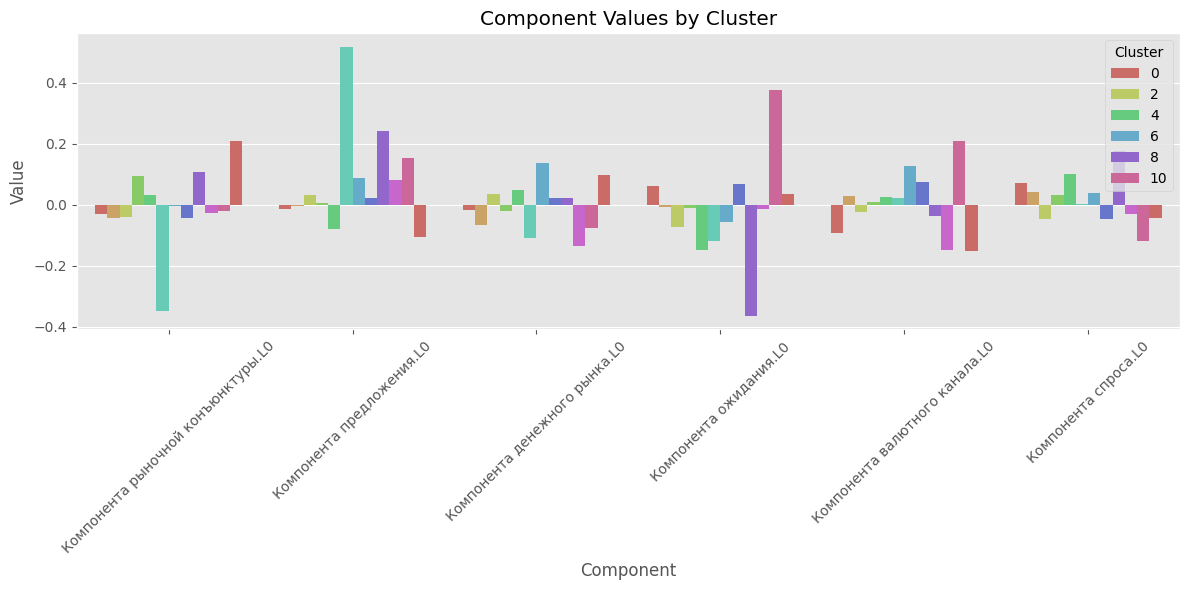


=== Cluster 0 ===
Регионы (9): Нижегородская_область, Архангельская_область, Московская_область, Республика_Башкортостан, Тульская_область, Карачаево-Черкесская_Республика, Кировская_область, Республика_Тыва, Липецкая_область

Средние значения компонент:
Компонента спроса.L0                  0.0702
Компонента ожидания.L0                0.0604
Компонента предложения.L0            -0.0150
Компонента денежного рынка.L0        -0.0186
Компонента рыночной конъюнктуры.L0   -0.0316
Компонента валютного канала.L0       -0.0923
Name: 0, dtype: float64

Ключевые компоненты: Компонента спроса.L0, Компонента ожидания.L0

=== Cluster 1 ===
Регионы (10): Амурская_область, Приморский_край, Астраханская_область, Тамбовская_область, Ярославская_область, Хабаровский_край, Саратовская_область, г._Москва, Ростовская_область, Воронежская_область

Средние значения компонент:
Компонента спроса.L0                  0.0421
Компонента валютного канала.L0        0.0282
Компонента предложения.L0            -0.005

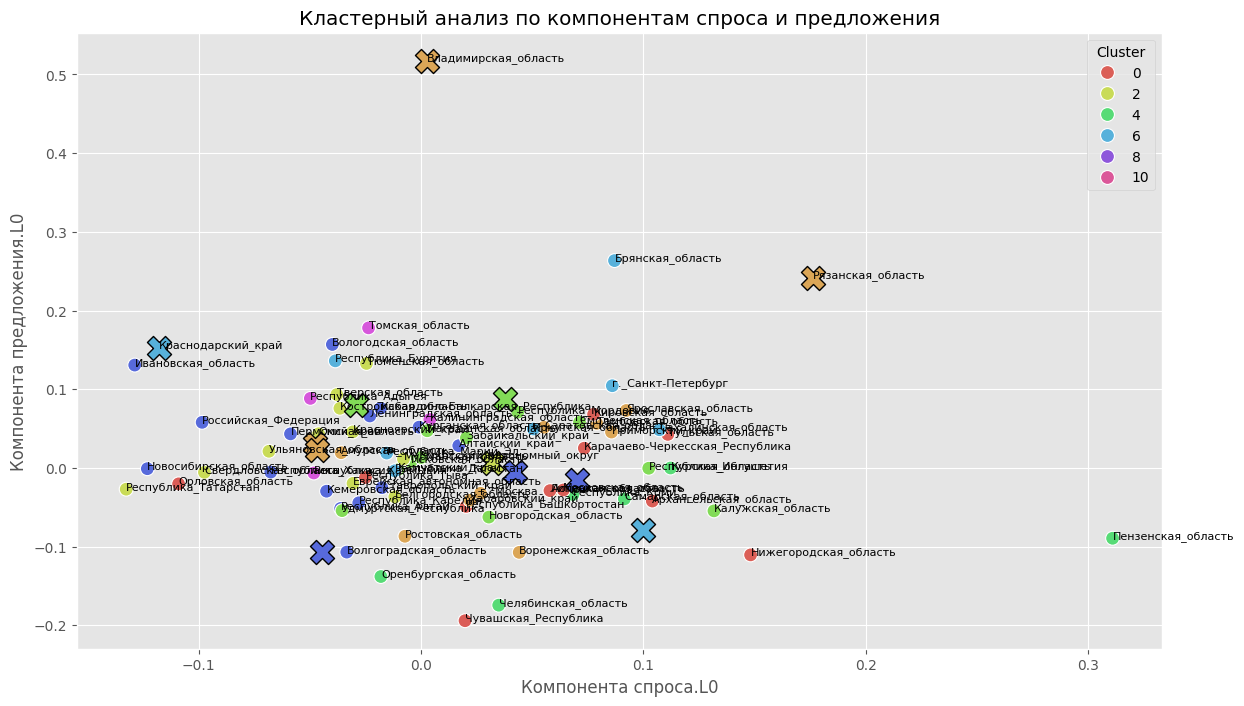

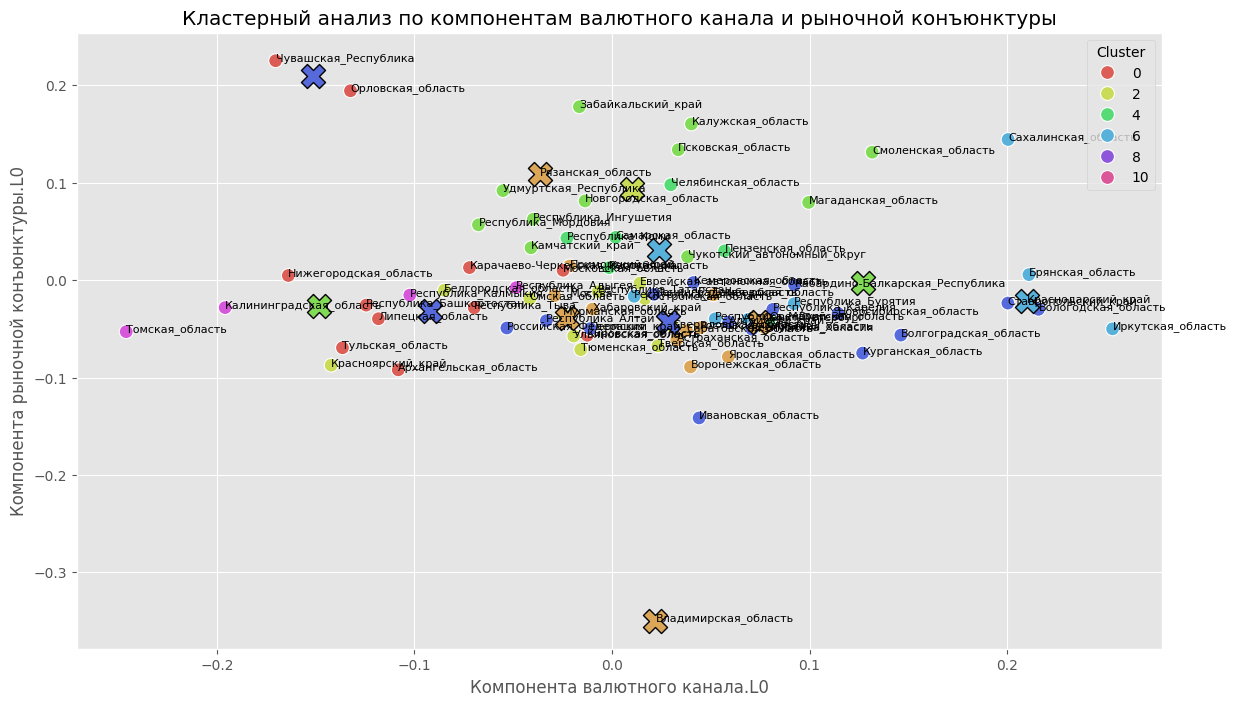

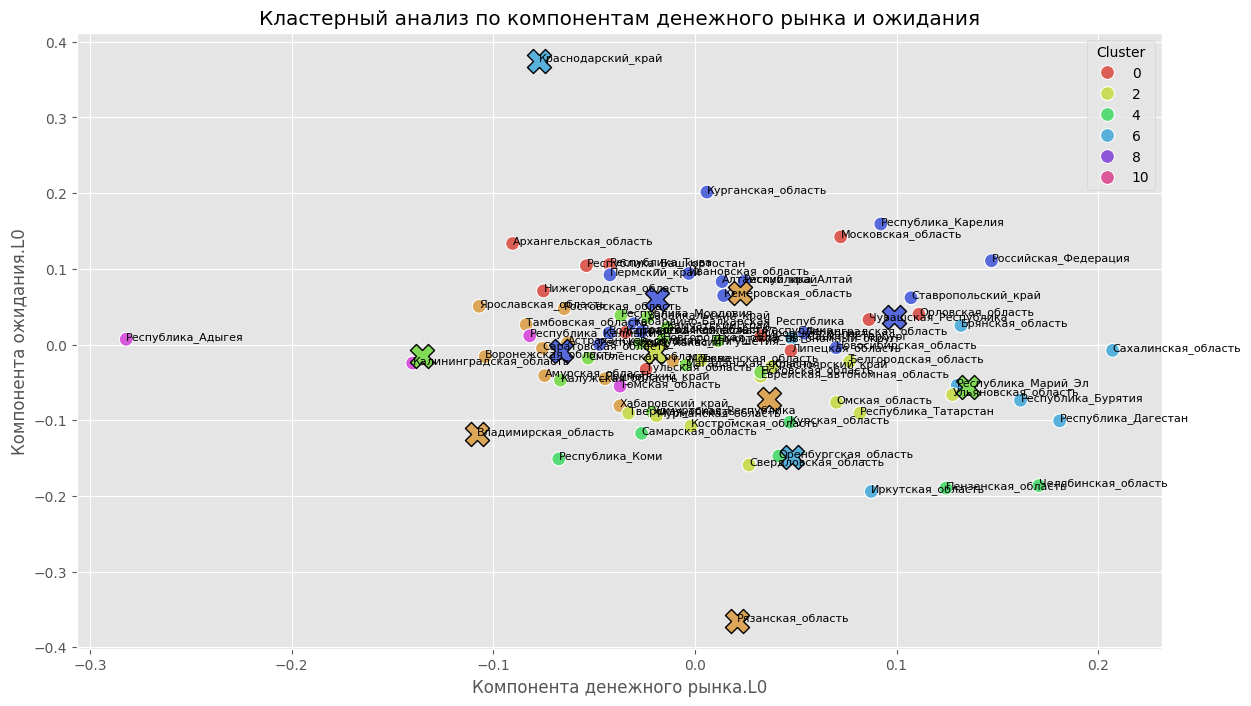

In [510]:
# Загрузка данных (предполагая, что данные уже в df)
# Транспонируем DataFrame, чтобы регионы стали наблюдениями
df = ardl_df_1.copy().T

# Выделяем только компоненты для кластеризации
components = ['Компонента рыночной конъюнктуры.L0', 'Компонента предложения.L0',
              'Компонента денежного рынка.L0', 'Компонента ожидания.L0',
              'Компонента валютного канала.L0', 'Компонента спроса.L0']
X = df[components]

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в DataFrame
df['Cluster'] = clusters

# Анализ центроидов кластеров
centroids = pd.DataFrame(scaler.inverse_transform(
    kmeans.cluster_centers_), columns=components)
centroids['Cluster'] = centroids.index

# Визуализация центроидов
plt.figure(figsize=(12, 6))
centroids_melted = centroids.melt(
    id_vars='Cluster', var_name='Component', value_name='Value')
sns.barplot(x='Component', y='Value', hue='Cluster',
            data=centroids_melted, palette='hls')
plt.xticks(rotation=45)
plt.title('Component Values by Cluster')
plt.tight_layout()
plt.show()

# Интерпретация кластеров
for cluster in range(n_clusters):
    print(f"\n=== Cluster {cluster} ===")
    cluster_regions = df[df['Cluster'] == cluster].index.tolist()
    print(f"Регионы ({len(cluster_regions)}): {', '.join(cluster_regions)}")

    cluster_components = centroids.loc[cluster,
                                       components].sort_values(ascending=False)
    print("\nСредние значения компонент:")
    print(cluster_components)

    # Определяем ключевые компоненты для кластера
    top_components = cluster_components.head(2)
    print(f"\nКлючевые компоненты: {', '.join(top_components.index)}")

# Дополнительная визуализация
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='Компонента спроса.L0', y='Компонента предложения.L0',
                          hue='Cluster', data=df, palette='hls', s=100)
for region in df.index:
    plt.text(df.loc[region, 'Компонента спроса.L0'],
             df.loc[region, 'Компонента предложения.L0'],
             region, fontsize=8)

centroids = df.groupby('Cluster')[
    ['Компонента спроса.L0', 'Компонента предложения.L0']].mean()
for cluster, (x, y) in centroids.iterrows():
    plt.scatter(x, y, s=300, marker='X', c=[scatter.get_children()[0].get_facecolor()[cluster]],
                edgecolors='black', linewidth=1, label=f'Центроид {cluster}')

plt.title('Кластерный анализ по компонентам спроса и предложения')
plt.show()

# Дополнительная визуализация
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='Компонента валютного канала.L0', y='Компонента рыночной конъюнктуры.L0',
                          hue='Cluster', data=df, palette='hls', s=100)
for region in df.index:
    plt.text(df.loc[region, 'Компонента валютного канала.L0'],
             df.loc[region, 'Компонента рыночной конъюнктуры.L0'],
             region, fontsize=8)

centroids = df.groupby('Cluster')[
    ['Компонента валютного канала.L0', 'Компонента рыночной конъюнктуры.L0']].mean()
for cluster, (x, y) in centroids.iterrows():
    plt.scatter(x, y, s=300, marker='X', c=[scatter.get_children()[0].get_facecolor()[cluster]],
                edgecolors='black', linewidth=1, label=f'Центроид {cluster}')

plt.title('Кластерный анализ по компонентам валютного канала и рыночной конъюнктуры')
plt.show()

# Дополнительная визуализация
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='Компонента денежного рынка.L0', y='Компонента ожидания.L0',
                          hue='Cluster', data=df, palette='hls', s=100)
for region in df.index:
    plt.text(df.loc[region, 'Компонента денежного рынка.L0'],
             df.loc[region, 'Компонента ожидания.L0'],
             region, fontsize=8)

centroids = df.groupby('Cluster')[
    ['Компонента денежного рынка.L0', 'Компонента ожидания.L0']].mean()
for cluster, (x, y) in centroids.iterrows():
    plt.scatter(x, y, s=300, marker='X', c=[scatter.get_children()[0].get_facecolor()[cluster]],
                edgecolors='black', linewidth=1, label=f'Центроид {cluster}')

plt.title('Кластерный анализ по компонентам денежного рынка и ожидания')
plt.show()

## XGBoost


### Без сглаживания шоков без PCA


Mean Squared Error: 0.0314
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


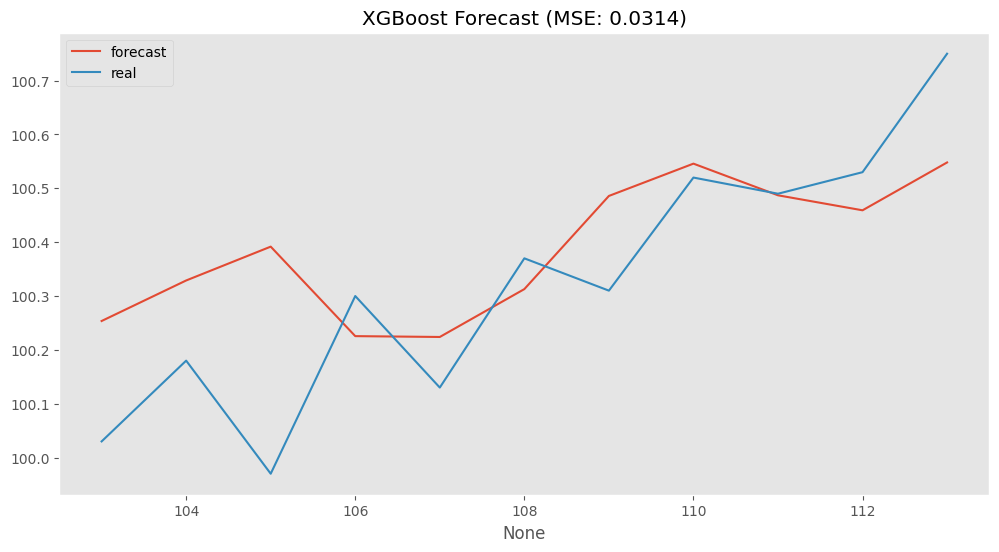

In [16]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()


def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)

# Разделяем на X и y
X_train_infl = train_feats.drop(
    columns=['inflation', 'ds'], axis=1).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds'], axis=1).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### Без сглаживания шоков с PCA


Mean Squared Error: 0.0363
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


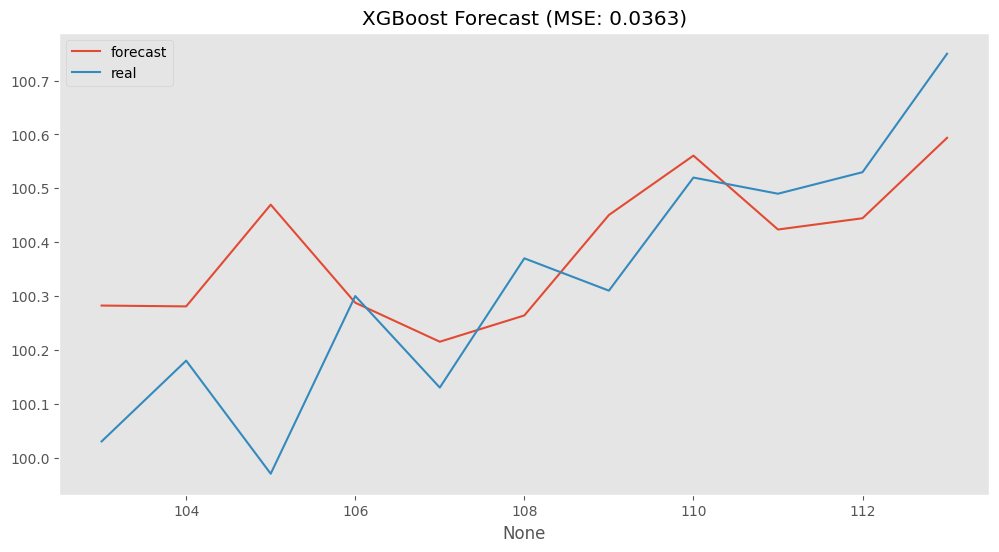

In [17]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков без PCA


Mean Squared Error: 0.0264
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


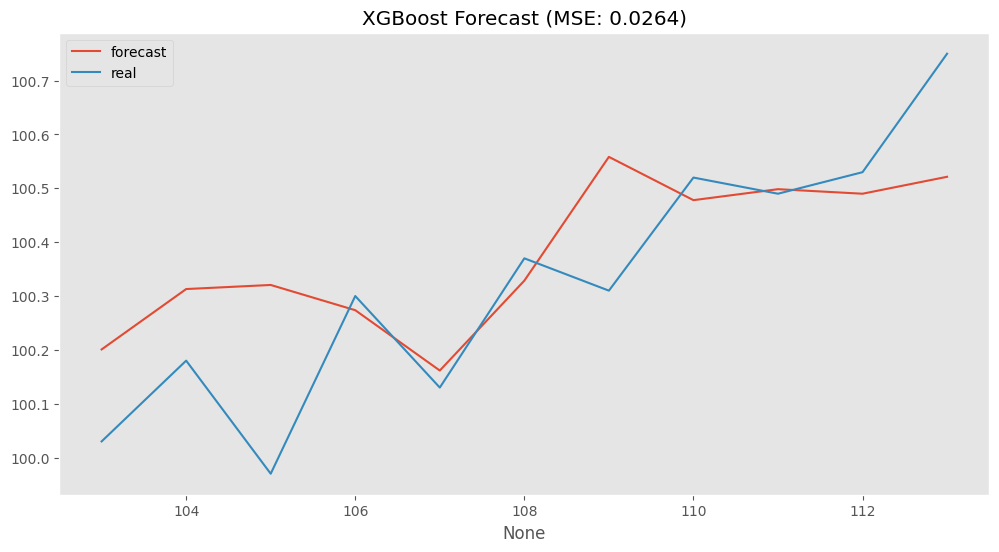

In [18]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков с PCA


/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_44588/2554253586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[98] = (y_train[97] + y_train[99]) / 2


Mean Squared Error: 0.0150
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


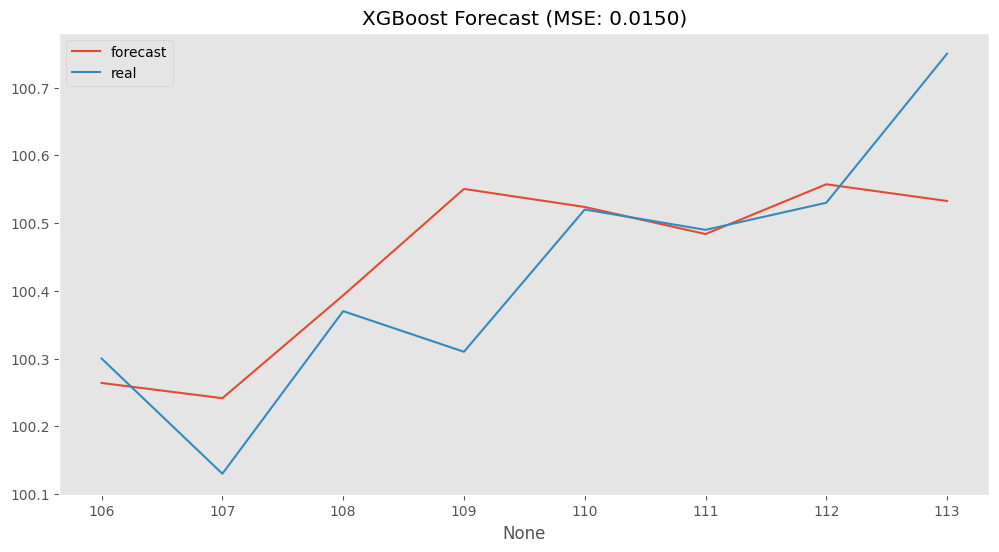

In [19]:
# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()